# 单变量时间序列；多元时间序列 
# LSTM执行多元时间序列预测

用 [feature1,feature2,feature3,feature4,target] 训练模型

为即将到来的预测目标提供4列[feature1,feature2,feature3,feature4]

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv("B0005.csv")
df.head()

,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
0,1,3.529829,32.572328,1622.625,1.856487
1,2,3.537320,32.725235,1661.078,1.846327
2,3,3.543737,32.642862,1661.922,1.835349
3,4,3.543666,32.514876,1662.906,1.835263
4,5,3.542343,32.382349,1661.938,1.834646


In [3]:
capacity_original_half = np.array(df)[:20,4]

In [4]:
capacity_original_half

array([1.85648742, 1.84632725, 1.83534919, 1.83526253, 1.83464551,
       1.83566166, 1.83514614, 1.82575679, 1.82477385, 1.82461327,
       1.82461955, 1.81420194, 1.81375216, 1.81344049, 1.802598  ,
       1.8021069 , 1.8025795 , 1.80306831, 1.80277763, 1.847026  ])

In [5]:
df.tail()

,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
163,164,3.466462,33.275688,805.656,1.293464
164,165,3.468509,33.320678,796.281,1.288003
165,166,3.466806,33.373150,795.937,1.287453
166,167,3.471071,33.713519,824.375,1.309015
167,168,3.475472,33.865318,843.109,1.325079


In [6]:
df.shape

(168, 5)

训练测试拆分

In [7]:
test_split=round(len(df)*0.30)
df_for_training=df[:120]
df_for_testing=df[120:]
print(df_for_training.shape)
print(df_for_testing.shape)
df_for_training

(120, 5)
(48, 5)


,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
0,1,3.529829,32.572328,1622.625,1.856487
1,2,3.537320,32.725235,1661.078,1.846327
2,3,3.543737,32.642862,1661.922,1.835349
3,4,3.543666,32.514876,1662.906,1.835263
4,5,3.542343,32.382349,1661.938,1.834646
...,...,...,...,...,...
115,116,3.491197,33.611268,974.343,1.417429
116,117,3.488909,33.455986,965.187,1.412409
117,118,3.487376,33.723267,974.297,1.412579
118,119,3.491994,34.050076,965.328,1.407598


MinMax归一化

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.fit_transform(df_for_testing)
df_for_testing_scaled[1]

array([0.0212766 , 0.94684274, 0.6931521 , 0.86393115, 0.86140613])

In [9]:
df_for_training_scaled[0:30,0:5]

array([[0.        , 0.553292  , 0.45672633, 0.89138334, 1.        ],
       [0.00840336, 0.65092999, 0.51294051, 0.94351961, 0.97736596],
       [0.01680672, 0.73455909, 0.48265711, 0.94466394, 0.95290991],
       [0.02521008, 0.73363867, 0.43560503, 0.94599809, 0.95271684],
       [0.03361345, 0.71639759, 0.38688315, 0.94468563, 0.95134229],
       [0.04201681, 0.70325333, 0.40593889, 0.94517103, 0.95360599],
       [0.05042017, 0.69921713, 0.42293628, 0.94506663, 0.95245757],
       [0.05882353, 0.87006007, 0.39721845, 0.94830845, 0.9315407 ],
       [0.06722689, 0.85445019, 0.37357171, 0.94589234, 0.92935099],
       [0.07563025, 0.83190441, 0.3480786 , 0.94669635, 0.92899325],
       [0.08403361, 0.80696645, 0.30407108, 0.94703667, 0.92900725],
       [0.09243697, 0.9433841 , 0.3801636 , 0.92216507, 0.9057997 ],
       [0.10084034, 0.92152407, 0.36329797, 0.9229501 , 0.90479772],
       [0.1092437 , 0.89037821, 0.3040699 , 0.89684875, 0.90410341],
       [0.11764706, 0.98232217, 0.

In [10]:
df_for_training_scaled[20,4]

0.979794316567955

将数据拆分训练集合测试集

In [11]:
# n_past是在预测下一个目标值时将在过去查看的步骤数
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past,len(dataset)):
        dataX.append(dataset[i - n_past:i,0:dataset.shape[1]])
        dataY.append(dataset[i,4])
    return np.array(dataX),np.array(dataY)

trainX , trainY = createXY(df_for_training_scaled,20)
testX , testY = createXY(df_for_testing_scaled,20)

In [12]:
print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)

(100, 20, 5)
(100,)
(28, 20, 5)
(28,)


In [13]:
df_for_testing_scaled.shape

(48, 5)

In [14]:
df_for_training_scaled.shape

(120, 5)

In [15]:
trainX[0]

array([[0.        , 0.553292  , 0.45672633, 0.89138334, 1.        ],
       [0.00840336, 0.65092999, 0.51294051, 0.94351961, 0.97736596],
       [0.01680672, 0.73455909, 0.48265711, 0.94466394, 0.95290991],
       [0.02521008, 0.73363867, 0.43560503, 0.94599809, 0.95271684],
       [0.03361345, 0.71639759, 0.38688315, 0.94468563, 0.95134229],
       [0.04201681, 0.70325333, 0.40593889, 0.94517103, 0.95360599],
       [0.05042017, 0.69921713, 0.42293628, 0.94506663, 0.95245757],
       [0.05882353, 0.87006007, 0.39721845, 0.94830845, 0.9315407 ],
       [0.06722689, 0.85445019, 0.37357171, 0.94589234, 0.92935099],
       [0.07563025, 0.83190441, 0.3480786 , 0.94669635, 0.92899325],
       [0.08403361, 0.80696645, 0.30407108, 0.94703667, 0.92900725],
       [0.09243697, 0.9433841 , 0.3801636 , 0.92216507, 0.9057997 ],
       [0.10084034, 0.92152407, 0.36329797, 0.9229501 , 0.90479772],
       [0.1092437 , 0.89037821, 0.3040699 , 0.89684875, 0.90410341],
       [0.11764706, 0.98232217, 0.

In [16]:
trainY[0]

0.979794316567955

In [17]:
testX[0]

array([[0.        , 1.        , 1.        , 1.        , 1.        ],
       [0.0212766 , 0.94684274, 0.6931521 , 0.86393115, 0.86140613],
       [0.04255319, 0.87372462, 0.41457355, 0.81974049, 0.79262045],
       [0.06382979, 0.77805937, 0.35366767, 0.72597339, 0.75430619],
       [0.08510638, 0.72510978, 0.36200192, 0.72907797, 0.72444624],
       [0.10638298, 0.6822132 , 0.34176396, 0.68321637, 0.68853149],
       [0.12765957, 0.62969298, 0.32252947, 0.68238331, 0.65500405],
       [0.14893617, 0.60775295, 0.22747117, 0.58982704, 0.61659559],
       [0.17021277, 0.62133261, 0.17919044, 0.58990938, 0.58211167],
       [0.19148936, 0.51184057, 0.21767978, 0.54737515, 0.5507885 ],
       [0.21276596, 0.45732294, 0.26619046, 0.54616432, 0.55076035],
       [0.23404255, 0.46131938, 0.20874721, 0.50045285, 0.51247818],
       [0.25531915, 0.5862227 , 0.68671641, 0.63592113, 0.5831435 ],
       [0.27659574, 0.78152743, 0.8259442 , 0.63720462, 0.65422653],
       [0.29787234, 0.69177487, 0.

In [18]:
learning_rate = 0.01
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(20,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1)

parameters = {'batch_size' : [16,24,28,32,40],
              'epochs' : [500,1000,1500],
              'optimizer' : ['adam'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_31392\1083356839.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1)


In [ ]:
grid_search = grid_search.fit(trainX,trainY,validation_data=(testX,testY))

Epoch 1/500
4/4 [==============================] - 9s 537ms/step - loss: 0.0590 - val_loss: 0.0128
Epoch 2/500
4/4 [==============================] - 0s 33ms/step - loss: 0.0201 - val_loss: 0.0069
Epoch 3/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0081 - val_loss: 0.0106
Epoch 4/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0055 - val_loss: 0.0349
Epoch 5/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0122 - val_loss: 0.0206
Epoch 6/500
4/4 [==============================] - 0s 40ms/step - loss: 0.0062 - val_loss: 0.0082
Epoch 7/500
4/4 [==============================] - 0s 36ms/step - loss: 0.0051 - val_loss: 0.0128
Epoch 8/500
4/4 [==============================] - 0s 36ms/step - loss: 0.0033 - val_loss: 0.0153
Epoch 9/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0032 - val_loss: 0.0123
Epoch 10/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0031 - val_loss: 0.0122
Epoch 11/500
4/4 [

Epoch 84/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0018 - val_loss: 0.0116
Epoch 85/500
4/4 [==============================] - 0s 42ms/step - loss: 0.0015 - val_loss: 0.0126
Epoch 86/500
4/4 [==============================] - 0s 46ms/step - loss: 0.0017 - val_loss: 0.0135
Epoch 87/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0021 - val_loss: 0.0158
Epoch 88/500
4/4 [==============================] - 0s 43ms/step - loss: 0.0021 - val_loss: 0.0165
Epoch 89/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0026 - val_loss: 0.0130
Epoch 90/500
4/4 [==============================] - 0s 40ms/step - loss: 0.0021 - val_loss: 0.0142
Epoch 91/500
4/4 [==============================] - 0s 44ms/step - loss: 0.0023 - val_loss: 0.0137
Epoch 92/500
4/4 [==============================] - 0s 45ms/step - loss: 0.0018 - val_loss: 0.0155
Epoch 93/500
4/4 [==============================] - 0s 40ms/step - loss: 0.0023 - val_loss: 0.0104
Epoch 94/5

4/4 [==============================] - 0s 43ms/step - loss: 0.0017 - val_loss: 0.0126
Epoch 167/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0020 - val_loss: 0.0118
Epoch 168/500
4/4 [==============================] - 0s 45ms/step - loss: 0.0016 - val_loss: 0.0138
Epoch 169/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0020 - val_loss: 0.0139
Epoch 170/500
4/4 [==============================] - 0s 45ms/step - loss: 0.0022 - val_loss: 0.0111
Epoch 171/500
4/4 [==============================] - 0s 44ms/step - loss: 0.0022 - val_loss: 0.0143
Epoch 172/500
4/4 [==============================] - 0s 42ms/step - loss: 0.0016 - val_loss: 0.0167
Epoch 173/500
4/4 [==============================] - 0s 38ms/step - loss: 0.0022 - val_loss: 0.0132
Epoch 174/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0015 - val_loss: 0.0118
Epoch 175/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0015 - val_loss: 0.0149
Epoch 176/500


4/4 [==============================] - 0s 43ms/step - loss: 0.0019 - val_loss: 0.0153
Epoch 249/500
4/4 [==============================] - 0s 44ms/step - loss: 0.0017 - val_loss: 0.0149
Epoch 250/500
4/4 [==============================] - 0s 37ms/step - loss: 0.0017 - val_loss: 0.0126
Epoch 251/500
4/4 [==============================] - 0s 48ms/step - loss: 0.0015 - val_loss: 0.0133
Epoch 252/500
4/4 [==============================] - 0s 43ms/step - loss: 0.0014 - val_loss: 0.0139
Epoch 253/500
4/4 [==============================] - 0s 42ms/step - loss: 0.0014 - val_loss: 0.0136
Epoch 254/500
4/4 [==============================] - 0s 46ms/step - loss: 0.0016 - val_loss: 0.0142
Epoch 255/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0016 - val_loss: 0.0136
Epoch 256/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0015 - val_loss: 0.0147
Epoch 257/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0016 - val_loss: 0.0180
Epoch 258/500


4/4 [==============================] - 0s 40ms/step - loss: 0.0019 - val_loss: 0.0142
Epoch 331/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0018 - val_loss: 0.0133
Epoch 332/500
4/4 [==============================] - 0s 36ms/step - loss: 0.0014 - val_loss: 0.0144
Epoch 333/500
4/4 [==============================] - 0s 40ms/step - loss: 0.0016 - val_loss: 0.0139
Epoch 334/500
4/4 [==============================] - 0s 45ms/step - loss: 0.0021 - val_loss: 0.0137
Epoch 335/500
4/4 [==============================] - 0s 46ms/step - loss: 0.0012 - val_loss: 0.0137
Epoch 336/500
4/4 [==============================] - 0s 44ms/step - loss: 0.0014 - val_loss: 0.0146
Epoch 337/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0017 - val_loss: 0.0148
Epoch 338/500
4/4 [==============================] - 0s 40ms/step - loss: 0.0019 - val_loss: 0.0128
Epoch 339/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0019 - val_loss: 0.0127
Epoch 340/500


4/4 [==============================] - 0s 41ms/step - loss: 0.0017 - val_loss: 0.0137
Epoch 413/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0012 - val_loss: 0.0133
Epoch 414/500
4/4 [==============================] - 0s 42ms/step - loss: 0.0013 - val_loss: 0.0132
Epoch 415/500
4/4 [==============================] - 0s 44ms/step - loss: 0.0015 - val_loss: 0.0139
Epoch 416/500
4/4 [==============================] - 0s 38ms/step - loss: 0.0016 - val_loss: 0.0134
Epoch 417/500
4/4 [==============================] - 0s 37ms/step - loss: 0.0015 - val_loss: 0.0128
Epoch 418/500
4/4 [==============================] - 0s 36ms/step - loss: 0.0017 - val_loss: 0.0139
Epoch 419/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0014 - val_loss: 0.0133
Epoch 420/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0015 - val_loss: 0.0142
Epoch 421/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0016 - val_loss: 0.0150
Epoch 422/500


4/4 [==============================] - 0s 37ms/step - loss: 0.0013 - val_loss: 0.0136
Epoch 495/500
4/4 [==============================] - 0s 43ms/step - loss: 0.0015 - val_loss: 0.0149
Epoch 496/500
4/4 [==============================] - 0s 38ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch 497/500
4/4 [==============================] - 0s 35ms/step - loss: 0.0013 - val_loss: 0.0139
Epoch 498/500
4/4 [==============================] - 0s 34ms/step - loss: 0.0013 - val_loss: 0.0146
Epoch 499/500
4/4 [==============================] - 0s 35ms/step - loss: 0.0013 - val_loss: 0.0151
Epoch 500/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0354
Epoch 1/500


In [ ]:
grid_search.best_params_

In [19]:
#保存最佳模型
my_model = grid_search.best_estimator_.model

In [20]:
prediction = my_model.predict(testX)
print("prediction\n",prediction)
print("\nPrediction Shape-",prediction.shape)

5/5 [==============================] - 1s 9ms/step
prediction
 [[1.0050822 ]
 [0.9937222 ]
 [0.98013794]
 [0.9699007 ]
 [0.96123886]
 [0.95620227]
 [0.95325685]
 [0.9512732 ]
 [0.9488208 ]
 [0.94750524]
 [0.94409776]
 [0.943105  ]
 [0.940222  ]
 [0.9333949 ]
 [0.9244195 ]
 [0.9164603 ]
 [0.91172516]
 [0.9031378 ]
 [0.8938222 ]
 [0.884982  ]
 [0.8764858 ]
 [0.86923873]
 [0.85946214]
 [0.84789693]
 [0.8369421 ]
 [0.82530093]
 [0.8168229 ]
 [0.81035185]
 [0.8183887 ]
 [0.8233019 ]
 [0.8194314 ]
 [0.8064836 ]
 [0.79117763]
 [0.7770753 ]
 [0.76368773]
 [0.74829483]
 [0.73452485]
 [0.7224057 ]
 [0.7125859 ]
 [0.70259726]
 [0.6898043 ]
 [0.6771055 ]
 [0.66487586]
 [0.6538766 ]
 [0.6425028 ]
 [0.63229394]
 [0.6192771 ]
 [0.60620654]
 [0.59360397]
 [0.5819042 ]
 [0.5702461 ]
 [0.5579069 ]
 [0.5465344 ]
 [0.5352853 ]
 [0.5235163 ]
 [0.51240766]
 [0.501423  ]
 [0.49022347]
 [0.48397186]
 [0.47511393]
 [0.4664893 ]
 [0.45972157]
 [0.45280161]
 [0.44436562]
 [0.43262073]
 [0.42012268]
 [0.40817958]

In [21]:
#逆缩放
prediction_copy = np.repeat(prediction,5,axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copy,(len(prediction),5)))[:,4]

In [22]:
pred.shape

(148,)

In [10]:
original_copy = np.repeat(testY,5, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copy,(len(testY),5)))[:,4]

NameError: name 'testY' is not defined

In [24]:
print("Pred Values -- ",pred)
print("\nOriginal Values -- ",original)

Pred Values --  [1.8593794 1.852915  1.8451853 1.8393599 1.8344309 1.8315649 1.8298889
 1.8287601 1.8273647 1.826616  1.824677  1.8241122 1.8224716 1.8185867
 1.8134795 1.8089503 1.8062559 1.8013694 1.7960685 1.7910382 1.7862035
 1.7820797 1.7765164 1.7699355 1.7637018 1.7570775 1.7522533 1.7485709
 1.7531443 1.7559401 1.7537376 1.7463698 1.7376602 1.7296355 1.7220175
 1.7132584 1.7054228 1.6985265 1.6929387 1.6872549 1.6799752 1.6727493
 1.6657901 1.6595312 1.653059  1.6472498 1.6398429 1.6324052 1.6252339
 1.6185763 1.6119425 1.6049211 1.5984497 1.5920486 1.5853516 1.5790304
 1.5727798 1.5664068 1.5628493 1.557809  1.5529011 1.5490501 1.5451125
 1.540312  1.5336288 1.526517  1.519721  1.5135013 1.5081816 1.5024955
 1.5025865 1.5024685 1.4993215 1.4944443 1.4877161 1.480771  1.4742277
 1.4680207 1.4625083 1.4571255 1.4518771 1.4468617 1.4418708 1.437225
 1.4340484 1.4289184 1.4226059 1.4152426 1.4090757 1.4031429 1.3970475
 1.3914111 1.3861399 1.3809621 1.3760523 1.3709397 1.3655851 1

In [21]:
original

In [ ]:
original.shape

In [ ]:
capacity_original_complete = np.append(capacity_original_half,original)
pred_complete = np.append(capacity_original_half,pred)

In [ ]:
capacity_original_half.shape

In [ ]:
capacity_original_complete.shape
pred_complete.shape

In [ ]:
plt.plot(pred_complete,color = 'blue',label = 'Predicted Capacity')
plt.plot(capacity_original_complete,color = 'red',label = 'Real Capacity')
plt.title('B0005 Battery')
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.legend()
plt.show()

评价

In [ ]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error MAE:", mean_absolute_error(original, pred))
print("mean_squared_error MSE:", mean_squared_error(original, pred))
print("rmse:", sqrt(mean_squared_error(original, pred)))
print("r2 score:", r2_score(original, pred))


# 预测未来值

In [ ]:
df

In [31]:
df_cycles_past = df.iloc[59:79,:]
df_cycles_past

,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
59,60,3.540920,32.400481,1386.125,1.694580
60,61,3.541196,32.293719,1377.266,1.684903
61,62,3.540671,32.136071,1358.031,1.674474
62,63,3.537605,32.382686,1358.188,1.674569
63,64,3.538422,32.309000,1339.453,1.663716
64,65,3.539286,32.566369,1340.234,1.659014
65,66,3.533690,32.465430,1321.282,1.653854
66,67,3.534368,32.347056,1311.406,1.642654
67,68,3.531294,32.371539,1302.266,1.637858
68,69,3.530913,32.455493,1292.609,1.632735


In [32]:
df_cycle_future=pd.read_csv("B5_test.csv")
df_cycle_future

,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
0,81,3.514773,32.219976,1180.563,1.559766
1,82,3.513299,32.712023,1170.906,1.559482
2,83,3.514485,32.945022,1162.032,1.554689
3,84,3.510968,32.857550,1152.125,1.548874
4,85,3.510936,32.629663,1142.672,1.538237
...,...,...,...,...,...
83,164,3.466462,33.275688,805.656,1.293464
84,165,3.468509,33.320678,796.281,1.288003
85,166,3.466806,33.373150,795.937,1.287453
86,167,3.471071,33.713519,824.375,1.309015


In [33]:
df_cycle_future["容量"] = 0

In [34]:
df_cycle_future

,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
0,81,3.514773,32.219976,1180.563,0
1,82,3.513299,32.712023,1170.906,0
2,83,3.514485,32.945022,1162.032,0
3,84,3.510968,32.857550,1152.125,0
4,85,3.510936,32.629663,1142.672,0
...,...,...,...,...,...
83,164,3.466462,33.275688,805.656,0
84,165,3.468509,33.320678,796.281,0
85,166,3.466806,33.373150,795.937,0
86,167,3.471071,33.713519,824.375,0


In [35]:
#剔除预测数据中容量列，归一化缩放，拼接20个预测输入和88个test点
df_cycle_future = df_cycle_future[["循环次数","平均放电电压","平均放电温度","等压降放电时间","容量"]]
old_scaled_array = scaler.transform(df_cycles_past)
new_scaled_array = scaler.transform(df_cycle_future)
new_scaled_df = pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,4] = np.nan
full_df = pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [36]:
full_df.loc[22]

0    0.491018
1    0.504222
2    0.589931
3    0.403723
4         NaN
Name: 22, dtype: float64

In [37]:
len(full_df.values)

108

In [103]:
#滚动填充容量数据预测
full_df_scaled_array = full_df.values
all_data = [] #预测值
time_step = 20
for i in range(time_step,len(full_df_scaled_array)):
    data_x = []
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x)
    prediction = my_model.predict(data_x)
    print(prediction)
    all_data.append(prediction)
    full_df.iloc[i,4] = prediction

[[0.45935774]]
[[0.4489388]]
[[0.4391241]]
[[0.42942214]]
[[0.4178005]]
[[0.40566766]]
[[0.39374888]]
[[0.38266796]]
[[0.37398708]]
[[0.36531937]]
[[0.36085868]]
[[0.35786694]]
[[0.35276556]]
[[0.34652162]]
[[0.3373913]]
[[0.32761192]]
[[0.31807116]]
[[0.308718]]
[[0.29937738]]
[[0.29123682]]
[[0.28354442]]
[[0.27588946]]
[[0.267864]]
[[0.25933343]]
[[0.2539001]]
[[0.24627618]]
[[0.23725729]]
[[0.22596891]]
[[0.21594699]]
[[0.20629734]]
[[0.19731134]]
[[0.18792659]]
[[0.17842683]]
[[0.16952112]]
[[0.16167557]]
[[0.15342224]]
[[0.14410613]]
[[0.13442707]]
[[0.12584694]]
[[0.11968462]]
[[0.11420985]]
[[0.11090464]]
[[0.10673344]]
[[0.10165462]]
[[0.09669979]]
[[0.09200233]]
[[0.08784716]]
[[0.08405001]]
[[0.08072613]]
[[0.07839133]]
[[0.07608128]]
[[0.07380247]]
[[0.07154465]]
[[0.07178435]]
[[0.07401209]]
[[0.07435311]]
[[0.07071149]]
[[0.06606643]]
[[0.06181186]]
[[0.05715518]]
[[0.05087905]]
[[0.04334184]]
[[0.03590266]]
[[0.03048528]]
[[0.02663385]]
[[0.02238641]]
[[0.01822928]]
[[0.

In [120]:
full_df_scaled_array[0 : , 0:full_df_scaled_array.shape[1]]
full_df

,0,1,2,3,4
0,0.353293,0.768359,0.391023,0.650848,0.715470
1,0.359281,0.771112,0.352025,0.641079,0.698464
2,0.365269,0.765870,0.294440,0.619867,0.680137
3,0.371257,0.735233,0.384523,0.620040,0.680304
4,0.377246,0.743403,0.357607,0.599379,0.661232
...,...,...,...,...,...
103,0.976048,0.024390,0.710716,0.010718,0.007048
104,0.982036,0.044840,0.727149,0.000379,0.004068
105,0.988024,0.027825,0.746316,0.000000,0.001868
106,0.994012,0.070436,0.870645,0.031361,-0.000386


In [121]:
#逆缩放
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_cycle = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,4]
print(y_pred_future_cycle)

[1.548843  1.5429144 1.5373294 1.5318086 1.5251956 1.5182916 1.5115094
 1.505204  1.5002643 1.495332  1.4927937 1.4910913 1.4881884 1.4846354
 1.47944   1.473875  1.468446  1.4631238 1.4578087 1.4531764 1.4487993
 1.4444433 1.4398764 1.4350224 1.4319305 1.4275923 1.4224603 1.4160367
 1.410334  1.4048429 1.3997295 1.3943894 1.3889836 1.3839159 1.3794516
 1.3747551 1.3694539 1.3639462 1.3590639 1.3555572 1.3524419 1.3505611
 1.3481876 1.3452976 1.3424782 1.339805  1.3374406 1.33528   1.3333884
 1.3320599 1.3307453 1.3294487 1.3281639 1.3283004 1.329568  1.3297621
 1.3276899 1.3250467 1.3226256 1.3199759 1.3164046 1.3121156 1.3078824
 1.3047997 1.3026081 1.3001912 1.2978256 1.2963585 1.2961994 1.2957429
 1.294604  1.2959688 1.297714  1.2992201 1.3003657 1.3005685 1.3003808
 1.299682  1.2988259 1.2979947 1.2968576 1.2951028 1.2935301 1.2914631
 1.2897673 1.2885153 1.287233  1.287133 ]


In [112]:
df_cycle_future

,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
0,81,3.514773,32.219976,1180.563,0
1,82,3.513299,32.712023,1170.906,0
2,83,3.514485,32.945022,1162.032,0
3,84,3.510968,32.857550,1152.125,0
4,85,3.510936,32.629663,1142.672,0
...,...,...,...,...,...
83,164,3.466462,33.275688,805.656,0
84,165,3.468509,33.320678,796.281,0
85,166,3.466806,33.373150,795.937,0
86,167,3.471071,33.713519,824.375,0


# 起始点为80 预测了末尾88个容量

In [145]:
capacity_original_half = np.array(df)[:80,4]
capacity_original_complete = np.array(df)[:,4]
len(capacity_original_half)

80

In [146]:
pred_complete = np.append(capacity_original_half,y_pred_future_cycle)

In [147]:
len(pred_complete)

168

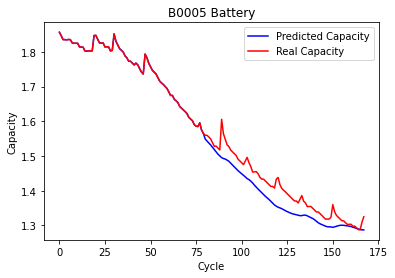

In [148]:
plt.plot(pred_complete,color = 'blue',label = 'Predicted Capacity')
plt.plot(capacity_original_complete,color = 'red',label = 'Real Capacity')
plt.title('B0005 Battery')
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.legend()
plt.show()

In [149]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error MAE:", mean_absolute_error(original, pred))
print("mean_squared_error MSE:", mean_squared_error(original, pred))
print("rmse:", sqrt(mean_squared_error(original, pred)))
print("r2 score:", r2_score(original, pred))

mean_absolute_error MAE: 0.026434296797807445
mean_squared_error MSE: 0.0009691936331100861
rmse: 0.031131874873031436
r2 score: 0.9689086541866203
